##### PART - I #####

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import spacy
import collections
import numpy as np
from spacy.en import English
import string
import unicodedata
import gensim
import re
from collections import Counter
from itertools import chain

import spacy
nlp = spacy.load('en')

parser = English()



sqd_data = pd.read_json("/data/train-v1.1.json")

In [2]:
sqd_data.head()

,data,version
0,"{'paragraphs': [{'context': 'Architecturally, ...",1.1
1,{'paragraphs': [{'context': 'Beyoncé Giselle K...,1.1
2,{'paragraphs': [{'context': 'Montana i/mɒnˈtæn...,1.1
3,"{'paragraphs': [{'context': 'The phrase ""in wh...",1.1
4,{'paragraphs': [{'context': 'The emergence of ...,1.1


In [3]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/home/aleena/Downloads/GoogleNews-vectors-negative300.3.bin', binary=True)


##### Prepare Stopwords list, question type mapping list, punctuation mark list #####

In [4]:
stopword = stopwords.words('english')
qtntype_list = ['How', 'What', 'When', 'Why', 'Which', 'Who','Whom', 'Where']
pun_list = list(string.punctuation)
delelements_list = stopword + qtntype_list + pun_list


In [5]:
qtntype_list

['How', 'What', 'When', 'Why', 'Which', 'Who', 'Whom', 'Where']

In [6]:
row_list = ['How many','How much','What','When','Where','Who', 'Which','Whom','PERSON',
          'NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
          'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE', 'ORG']


column_list = ['PERSON','NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
               'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE','ORG']

In [23]:
co_occ_matrix = np.zeros((len(row_list), len(column_list)), dtype = int)
co_occ_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
len(sqd_data)

442

## Real execution for 442 paragraphs

In [24]:
for i in range(len(sqd_data)):
    print(i)
    paragraph_pointer = sqd_data.data[i]['paragraphs'] 

    #print(i, " ", len(paragraph_pointer))
    for j in range(len(paragraph_pointer)):#no of paragraphs in a row of the df
        processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[j]['context']) 
        processed_que_list = preprocess_question(paragraph_pointer[j]['qas'])
        question_mapping = question_type(processed_que_list)
        que_type_extract = question_type_extractor(question_mapping)
        #print(que_type_extract)
        que_sen, ans_sen = wmd_que_ans_pair(processed_que_list, processed_sen_list)
        #print(wmd_dat)
#         print(que_sen)
#         print()
#         print(ans_sen)
        que_sen_map, ans_sen_map = que_ner_ans_ner(que_sen, ans_sen)
        que_no_quetag_df, que_no_anstag_df = que_df_ans_df(que_sen_map, ans_sen_map)
        
        for i in range(len(que_type_extract)):

            question_words = que_no_quetag_df[que_no_quetag_df['QuestionNo']== i]['QuestionTag'].tolist() + [que_type_extract[i]]
            ans_words = que_no_anstag_df[que_no_anstag_df['QuestionNo']==i]['AnswerTag'].tolist()
            combo = que_ans_combo_(question_words, ans_words)
            
            for i, v1 in enumerate(row_list):
                for j, v2 in enumerate(column_list):
                    for k in combo:
                        if [v1, v2] == k:
                            co_occ_matrix[i, j]+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)
co_occ_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,1586,1508,164,419,30,152,171,52,2734,114,336,232,489,5380,3520,3523
How much,322,271,20,83,14,26,18,19,729,24,337,352,80,531,655,693
What,20854,15945,1470,4521,464,1302,2092,825,19379,654,2130,859,3998,12807,29159,33116
When,3208,2246,187,583,60,252,299,98,4726,98,53,95,788,1676,4289,4536
Where,2065,1272,304,583,36,115,151,45,1443,33,38,35,398,974,3577,3096
Who,7619,3104,212,626,82,265,473,90,3782,81,79,92,925,1789,4884,6449
Which,3939,2295,337,830,86,210,360,111,2787,80,150,125,685,1747,4908,5022
Whom,295,133,10,24,1,12,15,5,153,0,4,3,40,60,217,263
PERSON,19567,4274,495,1135,156,394,1078,234,7373,213,200,236,1405,3766,8406,9714
NORP,4662,12453,218,1337,115,336,422,405,4295,93,708,133,849,2842,8372,5960


In [26]:
co_occ_matrix_df['Tags'] = co_occ_matrix_df.index

In [27]:
#heatmap
melt_co_occ_matrix_df = pd.melt(co_occ_matrix_df,id_vars = ['Tags'])
melt_co_occ_matrix_df.head()


import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_co_occ_matrix_df['value'],
                  x=melt_co_occ_matrix_df['Tags'] ,
                  y=melt_co_occ_matrix_df['variable'])
data=[trace]
py.iplot(data)

## Normalizing to bring out the pattern

In [28]:
from sklearn.preprocessing import normalize

In [29]:
normed_matrix = normalize(co_occ_matrix, axis=1, norm='l1')    #### dividing by sum of row...
normed_matrix

/data/Environment/finite_env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the normalize function.



array([[ 0.07770701,  0.07388535,  0.00803528,  0.02052915,  0.00146987,
         0.00744733,  0.00837825,  0.00254777,  0.13395394,  0.0055855 ,
         0.01646252,  0.01136698,  0.02395884,  0.26359628,  0.17246448,
         0.17261146],
       [ 0.07714423,  0.06492573,  0.00479157,  0.019885  ,  0.0033541 ,
         0.00622904,  0.00431241,  0.00455199,  0.17465261,  0.00574988,
         0.0807379 ,  0.08433158,  0.01916627,  0.1272161 ,  0.15692381,
         0.16602779],
       [ 0.13942169,  0.10660204,  0.00982785,  0.03022564,  0.00310212,
         0.00870466,  0.01398629,  0.00551563,  0.12956042,  0.00437239,
         0.01424035,  0.00574294,  0.02672907,  0.0856226 ,  0.19494568,
         0.22140064],
       [ 0.13831163,  0.09683539,  0.00806243,  0.02513581,  0.00258688,
         0.01086488,  0.01289126,  0.00422523,  0.20375959,  0.00422523,
         0.00228507,  0.00409589,  0.0339743 ,  0.07226007,  0.18491851,
         0.19556782],
       [ 0.14578186,  0.0897988 ,  0

In [30]:
normed_matrix_df = pd.DataFrame(normed_matrix, index = row_list, columns= column_list)
normed_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,0.077707,0.073885,0.008035,0.020529,0.001470,0.007447,0.008378,0.002548,0.133954,0.005585,0.016463,0.011367,0.023959,0.263596,0.172464,0.172611
How much,0.077144,0.064926,0.004792,0.019885,0.003354,0.006229,0.004312,0.004552,0.174653,0.005750,0.080738,0.084332,0.019166,0.127216,0.156924,0.166028
What,0.139422,0.106602,0.009828,0.030226,0.003102,0.008705,0.013986,0.005516,0.129560,0.004372,0.014240,0.005743,0.026729,0.085623,0.194946,0.221401
When,0.138312,0.096835,0.008062,0.025136,0.002587,0.010865,0.012891,0.004225,0.203760,0.004225,0.002285,0.004096,0.033974,0.072260,0.184919,0.195568
Where,0.145782,0.089799,0.021461,0.041158,0.002541,0.008119,0.010660,0.003177,0.101871,0.002330,0.002683,0.002471,0.028097,0.068761,0.252524,0.218567
Who,0.249378,0.101597,0.006939,0.020490,0.002684,0.008674,0.015482,0.002946,0.123789,0.002651,0.002586,0.003011,0.030276,0.058556,0.159859,0.211083
Which,0.166399,0.096950,0.014236,0.035063,0.003633,0.008871,0.015208,0.004689,0.117734,0.003380,0.006337,0.005281,0.028937,0.073800,0.207334,0.212149
Whom,0.238866,0.107692,0.008097,0.019433,0.000810,0.009717,0.012146,0.004049,0.123887,0.000000,0.003239,0.002429,0.032389,0.048583,0.175709,0.212955
PERSON,0.333646,0.072878,0.008440,0.019353,0.002660,0.006718,0.018381,0.003990,0.125720,0.003632,0.003410,0.004024,0.023957,0.064216,0.143335,0.165638
NORP,0.107917,0.288264,0.005046,0.030949,0.002662,0.007778,0.009769,0.009375,0.099421,0.002153,0.016389,0.003079,0.019653,0.065787,0.193796,0.137963


In [31]:
normed_matrix_df['Tags'] = normed_matrix_df.index

In [32]:
#normalized heatmap
melt_normed_matrix_df = pd.melt(normed_matrix_df,id_vars = ['Tags'])
melt_normed_matrix_df.head()


import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_normed_matrix_df['value'],
                  x=melt_normed_matrix_df['Tags'] ,
                  y=melt_normed_matrix_df['variable'])
data=[trace]
py.iplot(data)

In [33]:
melt_normed_matrix_df.columns = ['Question_tag', 'Answer_tag', 'z_value']
melt_normed_matrix_df.head()

,Question_tag,Answer_tag,z_value
0,How many,PERSON,0.077707
1,How much,PERSON,0.077144
2,What,PERSON,0.139422
3,When,PERSON,0.138312
4,Where,PERSON,0.145782


In [34]:
answer_dict = {'LOC': 1,'PERSON': 2,'NORP': 3,'FAC': 4,'PRODUCT': 5,'EVENT': 6,'WORK_OF_ART': 7,'LANGUAGE': 8,'DATE':9,'TIME': 10,'PERCENT': 11,'MONEY': 12,'ORDINAL': 13,'CARDINAL': 14,'GPE': 15, 'ORG': 16}

In [35]:
answer_dict

{'CARDINAL': 14,
 'DATE': 9,
 'EVENT': 6,
 'FAC': 4,
 'GPE': 15,
 'LANGUAGE': 8,
 'LOC': 1,
 'MONEY': 12,
 'NORP': 3,
 'ORDINAL': 13,
 'ORG': 16,
 'PERCENT': 11,
 'PERSON': 2,
 'PRODUCT': 5,
 'TIME': 10,
 'WORK_OF_ART': 7}

In [36]:
question_dict = {'LOC': 10,
                 'PERSON': 20,
                 'NORP': 30,
                 'FAC': 40,
                 'PRODUCT': 50,
                 'EVENT':60,
                 'WORK_OF_ART':70,
                 'LANGUAGE':80,
                 'DATE': 90,
                 'TIME': 100,
                 'PERCENT': 110,
                 'MONEY': 120,
                 'ORDINAL':130,
                 'CARDINAL': 140,
                 'GPE': 150,
                 'ORG': 160,
                 'How many': 170,
                 'How much': 180,
                 'What': 190,
                 'When': 200,
                 'Where': 210,
                 'Who': 220,
                 'Which':230,
                 'Whom': 240}

In [37]:
question_dict

{'CARDINAL': 140,
 'DATE': 90,
 'EVENT': 60,
 'FAC': 40,
 'GPE': 150,
 'How many': 170,
 'How much': 180,
 'LANGUAGE': 80,
 'LOC': 10,
 'MONEY': 120,
 'NORP': 30,
 'ORDINAL': 130,
 'ORG': 160,
 'PERCENT': 110,
 'PERSON': 20,
 'PRODUCT': 50,
 'TIME': 100,
 'WORK_OF_ART': 70,
 'What': 190,
 'When': 200,
 'Where': 210,
 'Which': 230,
 'Who': 220,
 'Whom': 240}

In [38]:
#created a copy of melt_normed_matrix_df
melt_normed_matrix_df_1 = melt_normed_matrix_df.copy()

In [39]:
melt_normed_matrix_df_1.head()

,Question_tag,Answer_tag,z_value
0,How many,PERSON,0.077707
1,How much,PERSON,0.077144
2,What,PERSON,0.139422
3,When,PERSON,0.138312
4,Where,PERSON,0.145782


In [40]:
melt_normed_matrix_df_1["Question_tag"].replace(question_dict, inplace=True)

In [41]:
melt_normed_matrix_df_1['Answer_tag'].replace(answer_dict, inplace = True)

In [42]:
melt_normed_matrix_df_1 #dataframe with tag2index mapped

,Question_tag,Answer_tag,z_value
0,170,2,0.077707
1,180,2,0.077144
2,190,2,0.139422
3,200,2,0.138312
4,210,2,0.145782
5,220,2,0.249378
6,230,2,0.166399
7,240,2,0.238866
8,20,2,0.333646
9,30,2,0.107917


In [552]:
# sales = [{'Question_type': 'Where', 'Answer_NER_tag': ['GPE', 'LOC']},
#         {'Question_type': 'What', 'Answer_NER_tag': ['GPE', 'LOC', 'PERSON', 'ORG', 'DATE']},
#         {'Question_type': 'When', 'Answer_NER_tag': ['DATE', 'TIME']},
#         {'Question_type': 'Who', 'Answer_NER_tag': ['PERSON', 'ORG']},
#         {'Question_type': 'How much', 'Answer_NER_tag': ['CARDINAL', 'MONEY']},
#         {'Question_type': 'How many', 'Answer_NER_tag': ['CARDINAL', 'ORDINAL']}]
# df = pd.DataFrame(sales)

## Logarithmic transformation
- log(1+X)

In [43]:
log_matrix = np.zeros((co_occ_matrix.shape))


In [44]:
for i in range(len(co_occ_matrix)):
    for j in range(len(co_occ_matrix[i])):
        log_matrix[i][j] = (np.log(1 + co_occ_matrix[i][j]))

In [45]:
log_matrix

array([[  7.36960072,   7.31920246,   5.10594547,   6.04025471,
          3.4339872 ,   5.03043792,   5.14749448,   3.97029191,
          7.91388671,   4.74493213,   5.82008293,   5.45103845,
          6.19440539,   8.59062951,   8.16650032,   8.16735199],
       [  5.77765232,   5.60580207,   3.04452244,   4.4308168 ,
          2.7080502 ,   3.29583687,   2.94443898,   2.99573227,
          6.59304453,   3.21887582,   5.8230459 ,   5.86646806,
          4.39444915,   6.27664349,   6.48616079,   6.54247196],
       [  9.94534901,   9.67696329,   7.29369772,   8.41670965,
          6.14203741,   7.17242458,   7.64635372,   6.71659477,
          9.87199689,   6.48463524,   7.66434663,   6.75693239,
          8.29379961,   9.45782525,  10.28055319,  10.40780202],
       [  8.07371464,   7.71735127,   5.23644196,   6.36990098,
          4.11087386,   5.53338949,   5.70378247,   4.59511985,
          8.46104603,   4.59511985,   3.98898405,   4.56434819,
          6.67076632,   7.42476176,  

In [46]:
log_matrix_df = pd.DataFrame(log_matrix, index = row_list, columns= column_list)
log_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,7.369601,7.319202,5.105945,6.040255,3.433987,5.030438,5.147494,3.970292,7.913887,4.744932,5.820083,5.451038,6.194405,8.590630,8.166500,8.167352
How much,5.777652,5.605802,3.044522,4.430817,2.708050,3.295837,2.944439,2.995732,6.593045,3.218876,5.823046,5.866468,4.394449,6.276643,6.486161,6.542472
What,9.945349,9.676963,7.293698,8.416710,6.142037,7.172425,7.646354,6.716595,9.871997,6.484635,7.664347,6.756932,8.293800,9.457825,10.280553,10.407802
When,8.073715,7.717351,5.236442,6.369901,4.110874,5.533389,5.703782,4.595120,8.461046,4.595120,3.988984,4.564348,6.670766,7.424762,8.364042,8.420021
Where,7.633370,7.149132,5.720312,6.369901,3.610918,4.753590,5.023881,3.828641,7.275172,3.526361,3.663562,3.583519,5.988961,6.882437,8.182559,8.038189
Who,8.938532,8.040769,5.361292,6.440947,4.418841,5.583496,6.161207,4.510860,8.238273,4.406719,4.382027,4.532599,6.830874,7.489971,8.493925,8.771835
Which,8.278936,7.738924,5.823046,6.722630,4.465908,5.351858,5.888878,4.718499,7.933080,4.394449,5.017280,4.836282,6.530878,7.466228,8.498826,8.521783
Whom,5.690359,4.897840,2.397895,3.218876,0.693147,2.564949,2.772589,1.791759,5.036953,0.000000,1.609438,1.386294,3.713572,4.110874,5.384495,5.575949
PERSON,9.881651,8.360539,6.206576,7.035269,5.056246,5.978886,6.983790,5.459586,8.905716,5.365976,5.303305,5.468060,7.248504,8.234034,9.036820,9.181426
NORP,8.447414,9.429797,5.389072,7.198931,4.753590,5.820083,6.047372,6.006353,8.365440,4.543295,6.563856,4.897840,6.745236,7.952615,9.032768,8.692994


In [47]:
log_matrix_df['Tags'] = log_matrix_df.index

In [48]:
#normalized heatmap
melt_log_matrix_df = pd.melt(log_matrix_df,id_vars = ['Tags'])
melt_log_matrix_df.head()



import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_log_matrix_df['value'],
                  x=melt_log_matrix_df['Tags'] ,
                  y=melt_log_matrix_df['variable'])
data=[trace]
py.iplot(data)

### Supriselib for latent factors

In [49]:
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy, Reader

In [77]:
reader_new = Reader(line_format='user item rating', sep='\t', rating_scale=(0,1))

In [50]:
reader = Reader(line_format='user item rating', sep='\t')

In [51]:
melt_normed_matrix_df_1.head()

,Question_tag,Answer_tag,z_value
0,170,2,0.077707
1,180,2,0.077144
2,190,2,0.139422
3,200,2,0.138312
4,210,2,0.145782


In [52]:
csv_file  = melt_normed_matrix_df_1.to_csv("melt.txt", sep= '\t', header = False, index = False)

In [78]:
melt = Dataset.load_from_file("/data/melt.txt", reader_new)

In [79]:
len(melt.raw_ratings)

384

In [80]:
algo = SVDpp(n_factors=10)

In [81]:
melt.split(n_folds=2)

In [82]:
for trainset, testset in melt.folds():
    algo.train(trainset)
    predictions_svdpp = algo.test(testset)
    rmse = accuracy.rmse(predictions_svdpp, verbose=True)

RMSE: 0.0596
RMSE: 0.0578


In [83]:
predict_df = pd.DataFrame(predictions_svdpp)
predict_df

,uid,iid,r_ui,est,details
0,130,11,0.003993,0.078941,{'was_impossible': False}
1,20,10,0.003632,0.020216,{'was_impossible': False}
2,100,9,0.164402,0.101535,{'was_impossible': False}
3,170,3,0.073885,0.119243,{'was_impossible': False}
4,230,8,0.004689,0.043400,{'was_impossible': False}
5,240,1,0.019433,0.000000,{'was_impossible': False}
6,80,3,0.227203,0.077213,{'was_impossible': False}
7,30,9,0.099421,0.149586,{'was_impossible': False}
8,90,15,0.155630,0.093233,{'was_impossible': False}
9,140,3,0.074737,0.091287,{'was_impossible': False}


In [84]:
algo.pu.shape #question_type latent factor matrix

(24, 10)

In [85]:
algo.qi.T.shape #answer_type latent factor matrix

(10, 16)

In [86]:
reconstruct = np.dot(algo.pu, algo.qi.T)

In [87]:
reconstruct

array([[-0.02840455,  0.00919799,  0.06350869,  0.01885121, -0.00462885,
         0.01207709, -0.02868511,  0.05683702, -0.05789528,  0.01153089,
         0.03112973, -0.0218944 ,  0.04947056, -0.03733781,  0.00933918,
        -0.0084507 ],
       [-0.02253275, -0.02740398, -0.00845903,  0.01917503, -0.00599748,
        -0.0023642 , -0.00299017,  0.02875872, -0.02863979, -0.02343489,
         0.00513539, -0.06795901,  0.02024072,  0.00728017, -0.04915129,
         0.00945441],
       [ 0.05427441,  0.01331502, -0.02814004, -0.00370518, -0.00866213,
         0.0292695 , -0.00143391, -0.02794861,  0.00252531,  0.00407488,
         0.00576483,  0.00222442,  0.00656141, -0.01065689, -0.03054747,
         0.01654994],
       [-0.01900079,  0.00925972, -0.00805688,  0.01882736, -0.00564963,
        -0.0337411 ,  0.02558186,  0.01816055, -0.01093561,  0.01770903,
        -0.00762479, -0.01624849, -0.02592715,  0.01221302, -0.02286954,
        -0.00291767],
       [-0.025872  ,  0.00560849,  0

In [88]:
reconstruct.shape

(24, 16)

In [89]:
reconstruct_error = normed_matrix - reconstruct

In [90]:
reconstruct_error

array([[  1.06111553e-01,   6.46873565e-02,  -5.54734131e-02,
          1.67794177e-03,   6.09871404e-03,  -4.62976436e-03,
          3.70633543e-02,  -5.42892500e-02,   1.91849221e-01,
         -5.94538977e-03,  -1.46672128e-02,   3.32613731e-02,
         -2.55117197e-02,   3.00934086e-01,   1.63125296e-01,
          1.81062167e-01],
       [  9.96769734e-02,   9.23297116e-02,   1.32505935e-02,
          7.09968446e-04,   9.35157322e-03,   8.59323221e-03,
          7.30257739e-03,  -2.42067278e-02,   2.03292406e-01,
          2.91847677e-02,   7.56025102e-02,   1.52290581e-01,
         -1.07445437e-03,   1.19935931e-01,   2.06075101e-01,
          1.56573378e-01],
       [  8.51472811e-02,   9.32870198e-02,   3.79678848e-02,
          3.39308158e-02,   1.17642535e-02,  -2.05648366e-02,
          1.54202086e-02,   3.34642420e-02,   1.27035110e-01,
          2.97508998e-04,   8.47551276e-03,   3.51851590e-03,
          2.01676563e-02,   9.62794836e-02,   2.25493148e-01,
          2.0485

In [91]:
import math
from sklearn.metrics import mean_squared_error

In [92]:
rmse = mean_squared_error(normed_matrix, reconstruct)**0.5

In [93]:
rmse

0.10256972580722713

In [94]:
reconstruction_error = []
for i in range(20):
    
    algo = SVDpp(n_factors=i)
    
    for trainset, testset in melt.folds():
        algo.train(trainset)
        predictions_svdpp = algo.test(testset)
        
    
    reconstruct = np.dot(algo.pu, algo.qi.T)
    rmse = mean_squared_error(normed_matrix, reconstruct)**0.5
    reconstruction_error.append(rmse)
    print(i, rmse)


0 0.0971167491171
1 0.0981225335763
2 0.0976952797785
3 0.0972523729407
4 0.099204601805
5 0.099039541734
6 0.0994280899714
7 0.0987590210539
8 0.101234584176
9 0.100282497607
10 0.104083887385
11 0.103157681759
12 0.101976227733
13 0.0996478460265
14 0.102635937162
15 0.100335377045
16 0.104002591573
17 0.106315851099
18 0.108692100534
19 0.104139293307


In [95]:
import matplotlib.pyplot as plt
plt.plot(range(20), reconstruction_error, marker='o')
plt.xlabel("n_factor")
plt.ylabel("rmse")
plt.title("Reconstruction error")

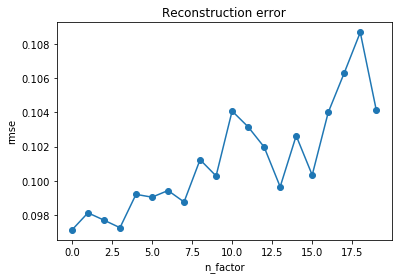

In [96]:
plt.show()

## TRIAL

In [403]:
sqd_data.data[1]['paragraphs']

[{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
  'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
    'id': '56be85543aeaaa14008c9063',
    'question': 'When did Beyonce start becoming popular?'},
   {'answers': [{'answer_start': 207, 'text': 'singing and dancing'}],
    'id': '56be85543aeaaa14008c9065',
  

In [420]:
co_occ_matrix = np.zeros((len(row_list), len(column_list)), dtype = int)
co_occ_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

### sample for a single context

In [421]:
paragraph_pointer = sqd_data.data[1]['paragraphs'] 

#print(i, " ", len(paragraph_pointer))
#for j in range(len(paragraph_pointer)):#no of paragraphs in a row of the df
processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[0]['context']) 
processed_que_list = preprocess_question(paragraph_pointer[0]['qas'])
print(processed_que_list)
print()
print(processed_sen_list)
question_mapping = question_type(processed_que_list)
print()
print(question_mapping)
que_type_extract = question_type_extractor(question_mapping)
print()
print(que_type_extract)
que_sen, ans_sen = wmd_que_ans_pair(processed_que_list, processed_sen_list)
#print(wmd_dat)
#         print(que_sen)
#         print()
#         print(ans_sen)
que_sen_map, ans_sen_map = que_ner_ans_ner(que_sen, ans_sen)
que_no_quetag_df, que_no_anstag_df = que_df_ans_df(que_sen_map, ans_sen_map)

for i in range(len(que_type_extract)):

    question_words = que_no_quetag_df[que_no_quetag_df['QuestionNo']== i]['QuestionTag'].tolist() + [que_type_extract[i]]
    ans_words = que_no_anstag_df[que_no_anstag_df['QuestionNo']==i]['AnswerTag'].tolist()
    combo = que_ans_combo_(question_words, ans_words)

    for i, v1 in enumerate(row_list):
        for j, v2 in enumerate(column_list):
            for k in combo:
                if [v1, v2] == k:
                    co_occ_matrix[i, j]+=1

['When did Beyonce start becoming popular?', 'What areas did Beyonce compete in When she was growing up?', "When did Beyonce leave Destiny's Child and become a solo singer?", 'In What city and state did Beyonce  grow up? ', 'In Which decade did Beyonce become famous?', 'In What R&B group was she the lead singer?', 'What album made her a worldwide known artist?', "Who managed the Destiny's Child group?", 'In What city did Beyonce grow up?', "What was the name of Beyonce's first solo album?", 'On What date was Beyonce born?', "What is Beyonce's full name?", 'When did Beyonce rise to fame?', "What role did Beyonce have in Destiny's Child?", 'What was the first album Beyonce released as a solo artist?', 'When did Beyonce release Dangerously in Love?', 'How many Grammy awards did Beyonce win for her first solo album?', "What was Beyonce's role in Destiny's Child?", "What was the name of Beyonce's first solo album?", 'When did Beyonce release her first solo album?']

['Beyonce Giselle Knowle

In [405]:
paragraph_pointer = sqd_data.data[1]['paragraphs'] 

#print(i, " ", len(paragraph_pointer))
for j in range(len(paragraph_pointer)):#no of paragraphs in a row of the df
    processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[j]['context']) 
    processed_que_list = preprocess_question(paragraph_pointer[j]['qas'])
    question_mapping = question_type(processed_que_list)
    que_type_extract = question_type_extractor(question_mapping)
    #print(que_type_extract)
    que_sen, ans_sen = wmd_que_ans_pair(processed_que_list, processed_sen_list)
    #print(wmd_dat)
#         print(que_sen)
#         print()
#         print(ans_sen)
    que_sen_map, ans_sen_map = que_ner_ans_ner(que_sen, ans_sen)
    que_no_quetag_df, que_no_anstag_df = que_df_ans_df(que_sen_map, ans_sen_map)

    for i in range(len(que_type_extract)):

        question_words = que_no_quetag_df[que_no_quetag_df['QuestionNo']== i]['QuestionTag'].tolist() + [que_type_extract[i]]
        ans_words = que_no_anstag_df[que_no_anstag_df['QuestionNo']==i]['AnswerTag'].tolist()
        combo = que_ans_combo_(question_words, ans_words)

        for i, v1 in enumerate(row_list):
            for j, v2 in enumerate(column_list):
                for k in combo:
                    if [v1, v2] == k:
                        co_occ_matrix[i, j]+=1

In [422]:
co_occ_matrix_df['Tags'] = co_occ_matrix_df.index

In [423]:
co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)
co_occ_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,1,0,0,0,0,0,2,0,1,0,0,0,0,3,1,1
How much,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
What,11,0,0,0,0,0,14,0,8,0,0,0,0,25,9,8
When,3,0,0,0,0,0,6,0,5,0,0,0,0,9,7,5
Where,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Who,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1
Which,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Whom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PERSON,3,0,0,0,0,0,4,0,3,0,0,0,0,7,4,3
NORP,1,0,0,0,0,0,2,0,1,0,0,0,0,3,1,1


In [401]:
#heatmap
melt_co_occ_matrix_df = pd.melt(co_occ_matrix_df,id_vars = ['Tags'])
melt_co_occ_matrix_df.head()


import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_co_occ_matrix_df['value'],
                  x=melt_co_occ_matrix_df['Tags'] ,
                  y=melt_co_occ_matrix_df['variable'])
data=[trace]
py.iplot(data)

In [463]:
context = sqd_data.data[0]['paragraphs'][0]['context'] 
context = unicodedata.normalize('NFKD', context).encode('ascii','ignore').decode('utf-8')
#print(context)
#sentence_tokeniztion
senttokenized_context = sent_tokenize(context)
sentencelist = []
for sent_token in senttokenized_context:
    sentencelist.append(sent_token) 

sentence_list = []
lemmatizer = WordNetLemmatizer()


for i in sentencelist:
    words = nltk.word_tokenize(i)
    words = ([x.lower() for x in words])
    words = ([x for x in words if x not in delelements_list])
    words = [lemmatizer.lemmatize(x) for x in words]
    words = [s.encode('ascii').decode('utf-8') for s in words]
    sentence_list.append(words)
#####################

print(sentencelist[0])

Architecturally, the school has a Catholic character.


In [441]:
question_list = []
for i in range(len(sqd_data.data[2]['paragraphs'][0]['qas'] )):
    l1 = sqd_data.data[2]['paragraphs'][0]['qas'][i]['question']
   
    l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')
    l1_token = nltk.word_tokenize(l1)
    if l1_token[-1] == '?':
        question_list.append(l1)
    
#print(question_list)    
    

    #print(question_list)
   # print()
#Appropriate question type replacement
#Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which"}, question_list[i]))
print(Question_list)

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Building at Notre Dame?', 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Building at Notre Dame?', 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Building at Notre Dame?', "Where does the state's name come from?", 'What is the states rank in size?', 'What is its rank 

In [442]:
Question_list

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'What sits on top of the Main Building at Notre Dame?',
 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'What sits on top of the Main Building at Notre Dame?',
 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'What sits on top of the Main Building at Notre Dame?',
 "Where does the state's name come from?",
 'What is the states rank in size?',
 '

In [161]:
w = ['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
     'What is in front of the Notre Dame Main Building?',
     'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
     'What is the Grotto at Notre Dame?',
     'The sits on top of the Main Building at Notre Dame is Whom?']
w

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'The sits on top of the Main Building at Notre Dame is Whom?']

In [362]:
w #a sample list tht i gave

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'The sits on top of the Main Building at Notre Dame is Whom?',
 'They said it will be fine but Why',
 'Why is she name d that way',
 'What /dshdgh she does / get from her?',
 'Why is it done??']

In [363]:
question_mapping = []
for i in range(len(w)):
    l2 = nltk.word_tokenize(w[i])
    print(len(l2))
    #print(l2)
    missed = l2[-1]
    
    if missed == '?':
        for j in range(len(l2)):


            if l2[j] in qtntype_list:
                combine_list = l2[j]+" "+l2[j+1]
                question_mapping.append(combine_list)

    else:

         for k in range(len(l2)):#8

            if k < len(l2)-1:  #7        

                if l2[k] in qtntype_list:
                    combine_list = l2[k]+" "+l2[k+1]
                    question_mapping.append(combine_list) 
            else:

                    if l2[k] in qtntype_list:
                        combine_list = l2[k]+" "+'abc'
                        question_mapping.append(combine_list)
print(question_mapping)

14
11
15
8
14
8
7
9
6
['Whom did', 'What is', 'Which structure', 'What is', 'Whom ?', 'Why abc', 'Why is', 'What /dshdgh', 'Why is']


In [38]:
def ans_mapping_fun(ans_list):
    
    for i in range(len(ans_list)):
        l1 = ' '.join(ans_list[i])
        answers.append(l1)
    print(answers)

    for i in range(len(answers)):
        doc = nlp(answers[i])
        for ent in doc.ents:
            ans_mapping.append(ent.label_)  
            ans_word.append(ent.text)
    return ans_mapping, ans_word
    #print(ans_word)
    #print(ans_mapping)

## Functions used:

In [10]:
def replace_all(repls, str):
   # return re.sub('|'.join(repls.keys()), lambda k: repls[k.group(0)], str)                                    
   return re.sub('|'.join(re.escape(key) for key in repls.keys()),
                 lambda k: repls[k.group(0)], str)

In [11]:
def preprocess_question(para_question):
    question_list = []
    for i in range(len(para_question)):
        l1 = para_question[i]['question']
        l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')
        question_list.append(l1)
    
    #Appropriate question type replacement
    Question_list = []
    for i in range(len(question_list)):
        Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where" }, question_list[i]))
        
    return Question_list   
        
        
        

In [12]:
def preprocess_text(para_context):

    context = unicodedata.normalize('NFKD', para_context).encode('ascii','ignore').decode('utf-8')
    #print(context)
    #sentence_tokeniztion
    senttokenized_context = sent_tokenize(context)
    sentencelist = []
    for sent_token in senttokenized_context:
        sentencelist.append(sent_token) 
    
    sentence_list = []
    lemmatizer = WordNetLemmatizer()


    for i in sentencelist:
        words = nltk.word_tokenize(i)
        words = ([x.lower() for x in words])
        words = ([x for x in words if x not in delelements_list])
        words = [lemmatizer.lemmatize(x) for x in words]
        words = [[s.encode('ascii').decode('utf-8') for s in words]]
        sentence_list.append(words)
    return sentencelist, sentence_list

In [13]:
def question_type_extractor(question_mapping):
    Question_mapping = []
    for i in range(len(question_mapping)):
        if question_mapping[i] != 'How many' and question_mapping[i] != 'How much':
            Question_mapping.append(question_mapping[i].split()[0])
        else:
             Question_mapping.append(question_mapping[i])
    return Question_mapping

In [14]:
def wmd_que_ans_pair(que_list, sen_list):
    wmd_matrix = np.zeros([len(que_list),len(sen_list)]) 
    for i in range(len(que_list)):
        for j in range(len(sen_list)):
            wmd_matrix[i,j] =  word2vec_model.wmdistance(que_list[i],sen_list[j])  
    wmd_df = pd.DataFrame(wmd_matrix)
    wmd_df['sentence'] = wmd_df.T.idxmin()
    wmd_df['qnno'] = wmd_df.index
    que_no_ans_sen_no = []
    for i in range(len(wmd_df)):
        que_no_ans_sen_no.append([wmd_df['qnno'][i], wmd_df['sentence'][i]])
    qn_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        if que_no_ans_sen_no[i][0] == que_list.index(que_list[i]):
            qn_sentence.append(que_list[i])
    an_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        for j in range(len(sen_list)):
            if que_no_ans_sen_no[i][1] == sen_list.index(sen_list[j]):
                an_sentence.append(sen_list[j]) 
    return qn_sentence, an_sentence

In [15]:
def que_ner_ans_ner(que_sentence, ans_sentence):
    ans_sentence_mapping = []
    for i in range(len(ans_sentence)):
        doc_ans = nlp(ans_sentence[i])
        for ent in doc_ans.ents:
            ans_sentence_mapping.append([i,ent.label_])

    que_sentence_mapping = []
    for i in range(len(que_sentence)):
        doc_que = nlp(que_sentence[i])
        for ent in doc_que.ents:
            que_sentence_mapping.append([i,ent.label_])
    return que_sentence_mapping, ans_sentence_mapping

In [16]:
def que_df_ans_df(que_sen_map, ans_sen_map):
    qno_anstag_df = pd.DataFrame(ans_sen_map,columns = ['QuestionNo','AnswerTag'])
    qno_quetag_df = pd.DataFrame(que_sen_map, columns = ['QuestionNo', 'QuestionTag'])
    return qno_quetag_df, qno_anstag_df 

In [17]:
def que_ans_combo_(questionword, answerword):
    ques_ans_combo = []
    for i in range(len(questionword)):
        for j in range(len(answerword)):
            ques_ans_combo.append([questionword[i],answerword[j]])
    return(ques_ans_combo)

In [18]:
def question_type(process_que_list):
    question_mapping = [] 
    for i in range(len(process_que_list)):
        l2 = nltk.word_tokenize(process_que_list[i])
        #print(len(l2))
        #print(l2)
        missed = l2[-1]        
        if missed == '?':
            for j in range(len(l2)):


                if l2[j] in qtntype_list:
                    combine_list = l2[j]+" "+l2[j+1]
                    question_mapping.append(combine_list)

        else:

             for k in range(len(l2)):#8

                if k < len(l2)-1:  #7        

                    if l2[k] in qtntype_list:
                        combine_list = l2[k]+" "+l2[k+1]
                        question_mapping.append(combine_list) 
                else:

                        if l2[k] in qtntype_list:
                            combine_list = l2[k]+" "+'abc'
                            question_mapping.append(combine_list) 
    return question_mapping

In [428]:
que_list = ['When did Beyonce start becoming popular?',
             'What areas did Beyonce compete in when she was growing up?',
             "When did Beyonce leave Destiny's Child and become a solo singer?",
             'In what city and state did Beyonce  grow up? ',
             'In which decade did Beyonce become famous?',
             'In what R&B group was she the lead singer?',
             'What album made her a worldwide known artist?',
             "Who managed the Destiny's Child group?",
             'In what city did Beyonce grow up?',
             "What was the name of Beyonce's first solo album?",
             'On what date was Beyonce born?',
             "What is Beyonce's full name?",
             'When did Beyonce rise to fame?',
             "What role did Beyonce have in Destiny's Child?",
             'What was the first album Beyonce released as a solo artist?',
             'When did Beyonce release Dangerously in Love?',
             'How many Grammy awards did Beyonce win for her first solo album?',
             "What was Beyonce's role in Destiny's Child?",
             "What was the name of Beyonce's first solo album?",
             'When did Beyonce release her first solo album?']

In [429]:
sen_list = ['Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.',
             "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.",
             "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.",
             'Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".']

In [360]:
w

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'The sits on top of the Main Building at Notre Dame is Whom?',
 'They said it will be fine but Why',
 'Why is she name d that way',
 'What /dshdgh she does / get from her?',
 'Why is it done??']

In [394]:
question_type(w) #sample check for the function

['Whom did',
 'What is',
 'Which structure',
 'What is',
 'Whom ?',
 'Why abc',
 'Why is',
 'What /dshdgh',
 'Why is']

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

##### Considering one matter from SQuAD data set - (Zeroth matter) ##### 

In [35]:
matter = sqd_data.data[1]['paragraphs'][0] 
matter

{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
   'id': '56be85543aeaaa14008c9063',
   'question': 'When did Beyonce start becoming popular?'},
  {'answers': [{'answer_start': 207, 'text': 'singing and dancing'}],
   'id': '56be85543aeaaa14008c9065',
   'ques

#################################################################################

##### Extraction of  context #####

##########################################################################33

In [139]:
len(sqd_data.data[1]['paragraphs'])

66

In [140]:
context = sqd_data.data[1]['paragraphs'][0]['context'] 
context = unicodedata.normalize('NFKD', context).encode('ascii','ignore').decode('utf-8')
context


'Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

##### Context pre processing ##### 

###### Sentence tokenization of the context #####

In [141]:
senttokenized_context = sent_tokenize(context)
sentencelist = []
for i in senttokenized_context:
      sentencelist.append(i) 

In [142]:
senttokenized_context

['Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.',
 "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.",
 "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.",
 'Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".']

##### Word tokenization, Lemmatisation, stop word removal #####

In [198]:
sentence_list = []
lemmatizer = WordNetLemmatizer()


for i in sentencelist:
    words = nltk.word_tokenize(i)
    words = ([x.lower() for x in words])
    words = ([x for x in words if x not in delelements_list])
    words = [lemmatizer.lemmatize(x) for x in words]
    words = [[s.encode('ascii').decode('utf-8') for s in words]]
    sentence_list.append(words)

    

In [199]:
sentence_list

[[['beyonce',
   'giselle',
   'knowles-carter',
   '/bijnse/',
   'bee-yon-say',
   'born',
   'september',
   '4',
   '1981',
   'american',
   'singer',
   'songwriter',
   'record',
   'producer',
   'actress']],
 [['born',
   'raised',
   'houston',
   'texas',
   'performed',
   'various',
   'singing',
   'dancing',
   'competition',
   'child',
   'rose',
   'fame',
   'late',
   '1990s',
   'lead',
   'singer',
   'r',
   'b',
   'girl-group',
   'destiny',
   "'s",
   'child']],
 [['managed',
   'father',
   'mathew',
   'knowles',
   'group',
   'became',
   'one',
   'world',
   "'s",
   'best-selling',
   'girl',
   'group',
   'time']],
 [['hiatus',
   'saw',
   'release',
   'beyonce',
   "'s",
   'debut',
   'album',
   'dangerously',
   'love',
   '2003',
   'established',
   'solo',
   'artist',
   'worldwide',
   'earned',
   'five',
   'grammy',
   'award',
   'featured',
   'billboard',
   'hot',
   '100',
   'number-one',
   'single',
   '``',
   'crazy',
   'love

##### Questions list ##### 

In [200]:
question_list = []
for i in range(len(sqd_data.data[1]['paragraphs'][0]['qas'])): 
    l1 = sqd_data.data[1]['paragraphs'][0]['qas'][i]['question'] 
    l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')

    question_list.append(l1) 

In [201]:
question_list

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'In what city did Beyonce grow up?',
 "What was the name of Beyonce's first solo album?",
 'On what date was Beyonce born?',
 "What is Beyonce's full name?",
 'When did Beyonce rise to fame?',
 "What role did Beyonce have in Destiny's Child?",
 'What was the first album Beyonce released as a solo artist?',
 'When did Beyonce release Dangerously in Love?',
 'How many Grammy awards did Beyonce win for her first solo album?',
 "What was Beyonce's role in Destiny's Child?",
 "What was the name of Beyonce's first solo album?",
 'When did Beyonce release her first solo album?']

* Keeping question's first word in upper case 

In [202]:
import re

def replace_all(repls, str):
    # return re.sub('|'.join(repls.keys()), lambda k: repls[k.group(0)], str)                                     
    return re.sub('|'.join(re.escape(key) for key in repls.keys()),
                  lambda k: repls[k.group(0)], str)     

In [203]:
Question_list = []
for i in range(len(question_list)): 
      Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which"}, question_list[i]) 
                          )

In [204]:
Question_list

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in When she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In What city and state did Beyonce  grow up? ',
 'In Which decade did Beyonce become famous?',
 'In What R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'In What city did Beyonce grow up?',
 "What was the name of Beyonce's first solo album?",
 'On What date was Beyonce born?',
 "What is Beyonce's full name?",
 'When did Beyonce rise to fame?',
 "What role did Beyonce have in Destiny's Child?",
 'What was the first album Beyonce released as a solo artist?',
 'When did Beyonce release Dangerously in Love?',
 'How many Grammy awards did Beyonce win for her first solo album?',
 "What was Beyonce's role in Destiny's Child?",
 "What was the name of Beyonce's first solo album?",
 'When did Beyonce release her first solo album?']

##### Mapping of questions #####

In [174]:
qtntype_list

['What', 'When', 'Why', 'Which', 'Who', 'Whom', 'How']

In [354]:
w = ['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
     'What is in front of the Notre Dame Main Building?',
     'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
     'What is the Grotto at Notre Dame?',
     'The sits on top of the Main Building at Notre Dame is Whom?',
     'They said it will be fine but Why',
      'Why is she name d that way',
       'What /dshdgh she does / get from her?',
        'Why is it done??']
w

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'The sits on top of the Main Building at Notre Dame is Whom?',
 'They said it will be fine but Why',
 'Why is she name d that way',
 'What /dshdgh she does / get from her?',
 'Why is it done??']

In [355]:
question_mapping= []
#delquestionpart_list = [] #delete question tag like what, why..
#stopwords_removed_qn = []

for i in range(len(w)):
    l2 = nltk.word_tokenize(w[i])
    print(len(l2))
    #print(l2)
    missed = l2[-1]
    print(missed)
    if missed == '?':
        for j in range(len(l2)):
           
           
            if l2[j] in qtntype_list:
                combine_list = l2[j]+" "+l2[j+1]
                question_mapping.append(combine_list)
                
    else:
        
         for k in range(len(l2)):#8
           
            if k < len(l2)-1:  #7        
                
                if l2[k] in qtntype_list:
                    combine_list = l2[k]+" "+l2[k+1]
                    question_mapping.append(combine_list) 
            else:
                
                    if l2[k] in qtntype_list:
                        combine_list = l2[k]+" "+'abc'
                        question_mapping.append(combine_list) 
                    
                    
print(question_mapping)                    
                    
#             else:
                
#                 if missed in qtntype_list:
#                     b = missed + " " + 'abc' #abc being an extra word
#                     question_mapping.append(b)

#print(question_mapping)                
                    #remove_list = combine_list.split() 
#                 l3 = [x for x in l2 if x not in remove_list]
#                 l4 = [x for x in l2 if x not in stopword]
                
       
            
#question_mapping.append(combine_list) 
#                 delquestionpart_list.append(l3) 
#                 stopwords_removed_qn.append(l4) 
                



14
?
11
?
15
?
8
?
14
?
8
Why
7
way
9
?
6
?
['Whom did', 'What is', 'Which structure', 'What is', 'Whom ?', 'Why abc', 'Why is', 'What /dshdgh', 'Why is']


In [330]:
for i in range(len(w)):
    l2 = nltk.word_tokenize(w[i])
    print(l2)

['To', 'Whom', 'did', 'the', 'Virgin', 'Mary', 'allegedly', 'appear', 'in', '1858', 'in', 'Lourdes', 'France', '?']
['What', 'is', 'in', 'front', 'of', 'the', 'Notre', 'Dame', 'Main', 'Building', '?']
['The', 'Basilica', 'of', 'the', 'Sacred', 'heart', 'at', 'Notre', 'Dame', 'is', 'beside', 'to', 'Which', 'structure', '?']
['What', 'is', 'the', 'Grotto', 'at', 'Notre', 'Dame', '?']
['The', 'sits', 'on', 'top', 'of', 'the', 'Main', 'Building', 'at', 'Notre', 'Dame', 'is', 'Whom', '?']
['They', 'said', 'it', 'will', 'be', 'fine', 'but', 'Why']


In [345]:
qtntype_list

['What', 'When', 'Why', 'Which', 'Who', 'Whom', 'How']

In [322]:
p.append(2)
p

[1, 2]

In [323]:
p.append(3)
p

[1, 2, 3]

In [324]:
p.append(4)
p

[1, 2, 3, 4]

In [ ]:
que_word_token = []
ex = ['abc']
for i in range(len(w)):
    que_word_token.append(nltk.word_tokenize(w[i]))

    
for i in range(len(que_word_token)):
     if que_word_token[i][-2] in qtntype_list:
            a = [que_word_token[i][-2]]
            b = a + ex

In [253]:
question_mapping

['When did',
 'What areas',
 'When she',
 'When did',
 'What city',
 'Which decade',
 'What R',
 'What album',
 'Who managed',
 'What city',
 'What was',
 'What date',
 'What is',
 'When did',
 'What role',
 'What was',
 'When did',
 'How many',
 'What was',
 'What was',
 'When did']

In [251]:
Question_list[8]

'In What city did Beyonce grow up?'

##### Converting question sentence into 'unicode' structure for NER ##### - not needed
- deleted question tags from every question sentence

In [225]:
joined_delquestionpart_list =  []
for i in range(len(delquestionpart_list)):
        joined_question = " ".join(delquestionpart_list[i])
        joined_delquestionpart_list.append(joined_question) 

In [226]:
len(joined_delquestionpart_list)


21

In [228]:
qn_ner_mapping = []
for i in range(len(joined_delquestionpart_list)):
    doc = nlp(joined_delquestionpart_list[i])
    for ent in doc.ents:
        qn_ner_mapping.append([i,ent.text,ent.label_])  

In [230]:
qn_ner_mapping

[[3, "Destiny 's Child", 'WORK_OF_ART'],
 [9, 'Beyonce', 'PERSON'],
 [10, 'Beyonce', 'PERSON'],
 [10, 'first', 'ORDINAL'],
 [12, 'Beyonce', 'PERSON'],
 [14, "Destiny 's Child", 'WORK_OF_ART'],
 [15, 'first', 'ORDINAL'],
 [15, 'Beyonce', 'GPE'],
 [16, 'Dangerously', 'GPE'],
 [16, 'Love', 'WORK_OF_ART'],
 [17, 'first', 'ORDINAL'],
 [18, "Destiny 's Child", 'WORK_OF_ART'],
 [19, 'Beyonce', 'PERSON'],
 [19, 'first', 'ORDINAL'],
 [20, 'first', 'ORDINAL']]

In [243]:
doc = nlp("In What city did Beyonce grow up?")
for ent in doc.ents:
    print([ent.text,ent.label_])  

['Beyonce', 'GPE']


##### Data frame for QUESTION mapping #####
- dissecting the question sentence only

In [414]:
qn_ner_mapping

[[3, "Destiny 's Child", 'WORK_OF_ART'],
 [9, 'Beyonce', 'PERSON'],
 [10, 'Beyonce', 'PERSON'],
 [10, 'first', 'ORDINAL'],
 [12, 'Beyonce', 'PERSON'],
 [14, "Destiny 's Child", 'WORK_OF_ART'],
 [15, 'first', 'ORDINAL'],
 [15, 'Beyonce', 'GPE'],
 [16, 'Dangerously', 'GPE'],
 [16, 'Love', 'WORK_OF_ART'],
 [17, 'first', 'ORDINAL'],
 [18, "Destiny 's Child", 'WORK_OF_ART'],
 [19, 'Beyonce', 'PERSON'],
 [19, 'first', 'ORDINAL'],
 [20, 'first', 'ORDINAL']]

In [254]:
Question_no = []
Qn_word = [] 
Qn_tag = []
for i in range(len(qn_ner_mapping)):
    Question_no.append(qn_ner_mapping[i][0])
    Qn_word.append(qn_ner_mapping[i][1])
    Qn_tag.append(qn_ner_mapping[i][2])
     

In [255]:
Question_character_df = pd.DataFrame()
qn_mapping = []
for i in range(len(Question_no)):
    for j in range(len(question_mapping)):
        if (Question_no[i]) == j:
            qn_mapping.append(question_mapping[j])


Question_character_df['QuestionNO'] = Question_no
Question_character_df['QuestionMapping'] = qn_mapping 
Question_character_df['Word'] = Qn_word
Question_character_df['WordTag'] = Qn_tag


##### Question - mapping #####

In [256]:
Question_character_df

,QuestionNO,QuestionMapping,Word,WordTag
0,3,When did,Destiny 's Child,WORK_OF_ART
1,9,What city,Beyonce,PERSON
2,10,What was,Beyonce,PERSON
3,10,What was,first,ORDINAL
4,12,What is,Beyonce,PERSON
5,14,What role,Destiny 's Child,WORK_OF_ART
6,15,What was,first,ORDINAL
7,15,What was,Beyonce,GPE
8,16,When did,Dangerously,GPE
9,16,When did,Love,WORK_OF_ART


################################################################################################################

##### Context preprocessing ##### 

In [257]:
context = sqd_data.data[1]['paragraphs'][0]['context'] 
context = unicodedata.normalize('NFKD', context).encode('ascii','ignore').decode('utf-8')
context

'Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

##### Sentence tokenization #####

In [258]:
senttokenized_context = sent_tokenize(context)
sentencelist = []
for i in senttokenized_context:
      sentencelist.append(i) 

In [259]:
senttokenized_context


['Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.',
 "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.",
 "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.",
 'Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".']

###### PART -II #####

##### Word move Distance for extracting Answer sentence from the text #####

##### Construction of word move distance matrix #####

In [260]:

len(senttokenized_context)

4

In [262]:

question_list

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'In what city did Beyonce grow up?',
 "What was the name of Beyonce's first solo album?",
 'On what date was Beyonce born?',
 "What is Beyonce's full name?",
 'When did Beyonce rise to fame?',
 "What role did Beyonce have in Destiny's Child?",
 'What was the first album Beyonce released as a solo artist?',
 'When did Beyonce release Dangerously in Love?',
 'How many Grammy awards did Beyonce win for her first solo album?',
 "What was Beyonce's role in Destiny's Child?",
 "What was the name of Beyonce's first solo album?",
 'When did Beyonce release her first solo album?']

In [432]:
wmd_matrix = np.zeros([len(question_list),len(sentence_list)]) 
for i in range(len(question_list)):
    for j in range(len(senttokenized_context)):
        wmd_matrix[i,j] =  word2vec_model.wmdistance(question_list[i],senttokenized_context[j])  


##### Word mover  distance for each question across all sentences #####

* Rows indicates question number and column represents sentence number 

In [264]:
wmd_df = pd.DataFrame(wmd_matrix) 

In [265]:
wmd_df

,0,1,2,3
0,0.895393,0.744064,0.826137,0.746238
1,0.786358,0.798702,0.680607,0.759209
2,0.861740,0.823296,1.004824,0.727420
3,1.222830,0.961409,1.118539,1.045657
4,1.207344,1.321630,1.114671,1.022527
5,1.104582,0.923385,0.789637,0.934271
6,1.269877,1.080827,0.944633,0.918117
7,1.160023,0.753293,0.854667,0.834716
8,1.356013,1.030364,1.188003,1.154958
9,1.114610,1.015443,0.752341,0.802786


##### Add a new column 'sentence' indicating the answer sentence ##### 

In [266]:
wmd_df['sentence'] = wmd_df.T.idxmin()


In [267]:
wmd_df

,0,1,2,3,sentence
0,0.895393,0.744064,0.826137,0.746238,1
1,0.786358,0.798702,0.680607,0.759209,2
2,0.861740,0.823296,1.004824,0.727420,3
3,1.222830,0.961409,1.118539,1.045657,1
4,1.207344,1.321630,1.114671,1.022527,3
5,1.104582,0.923385,0.789637,0.934271,2
6,1.269877,1.080827,0.944633,0.918117,3
7,1.160023,0.753293,0.854667,0.834716,1
8,1.356013,1.030364,1.188003,1.154958,1
9,1.114610,1.015443,0.752341,0.802786,2


In [268]:
wmd_df['qnno'] = wmd_df.index
qn_ans = []

for i in range(len(wmd_df)):
    qn_ans.append([wmd_df['qnno'][i], wmd_df['sentence'][i]])

In [269]:
qn_ans

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 1],
 [4, 3],
 [5, 2],
 [6, 3],
 [7, 1],
 [8, 1],
 [9, 2],
 [10, 3],
 [11, 3],
 [12, 3],
 [13, 3],
 [14, 2],
 [15, 3],
 [16, 3],
 [17, 3],
 [18, 2],
 [19, 3]]

##### Mapping "Question and Answers"  #####

In [270]:
qn_sentence = []
for i in range(len(qn_ans)):
    if qn_ans[i][0] == question_list.index(question_list[i]):
        qn_sentence.append(question_list[i])
an_sentence = []
for i in range(len(qn_ans)):
    for j in range(len(senttokenized_context)):
        if qn_ans[i][1] == senttokenized_context.index(senttokenized_context[j]):
            an_sentence.append(senttokenized_context[j]) 

            

In [271]:
qn_sentence

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'In what city did Beyonce grow up?',
 "What was the name of Beyonce's first solo album?",
 'On what date was Beyonce born?',
 "What is Beyonce's full name?",
 'When did Beyonce rise to fame?',
 "What role did Beyonce have in Destiny's Child?",
 'What was the first album Beyonce released as a solo artist?',
 'When did Beyonce release Dangerously in Love?',
 'How many Grammy awards did Beyonce win for her first solo album?',
 "What was Beyonce's role in Destiny's Child?",
 'When did Beyonce release her first solo album?']

##### NER for "Question sentence"  and "Answer sentence" #####

In [272]:
an_sentence_mapping = []
for i in range(len(an_sentence)):
    doc = nlp(an_sentence[i])
    for ent in doc.ents:
        an_sentence_mapping.append([i,ent.label_])  

In [273]:
qn_sentence_mapping = []
for i in range(len(qn_sentence)):
    doc = nlp(qn_sentence[i])
    for ent in doc.ents:
        qn_sentence_mapping.append([i,ent.label_])  

##### Editing  Question words #####

- Remove stopwords like "did" ,"is", "was" from "question words".

In [322]:
#sample done on 0th context under the title notre dame
Question_mapping = []
for i in range(len(question_mapping)):
    if question_mapping[i] != 'How many' and question_mapping[i] != 'How much':
        Question_mapping.append(question_mapping[i].split()[0])
    else:
         Question_mapping.append(question_mapping[i])

In [323]:
Question_mapping

['When',
 'What',
 'When',
 'When',
 'What',
 'Which',
 'What',
 'What',
 'Who',
 'What',
 'What',
 'What',
 'What',
 'When',
 'What',
 'What',
 'When',
 'How many',
 'What',
 'What',
 'When']

In [324]:
Question_character_df = pd.DataFrame()
qn_mapping = []
for i in range(len(Question_no)):
    for j in range(len(Question_mapping)):
        if (Question_no[i]) == j:
            qn_mapping.append(Question_mapping[j])


Question_character_df['QuestionNo'] = Question_no
Question_character_df['QuestionMapping'] = qn_mapping
Question_character_df['Word'] = Qn_word
Question_character_df['WordTag'] = Qn_tag


#####  Create a co occurrence matrix #####

In [339]:
row_list = ['How many','How much','What','When','Where','Who', 'Which','Whom','PERSON',
           'NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
           'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE','ORG']

column_list = ['PERSON',
           'NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
           'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE', 'ORG'] 

In [340]:
co_occ_matrix = np.zeros((len(row_list), len(column_list)), dtype = int)
co_occ_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

##### Creating a list of lists with question-answer NER tag #####

In [341]:
def que_ans_combo_(question_words, ans_words):
    ques_ans_combo = []
    for i in range(len(question_words)):
        for j in range(len(ans_words)):
            ques_ans_combo.append([question_words[i],ans_words[j]])
    return(ques_ans_combo) 

##### Filling in the co occurrence matrix with corresponding count #####



In [342]:
Answer_character_df = pd.DataFrame(an_sentence_mapping,columns = ['QuestionNo','Answer_WordTag'])
Answer_character_df

,QuestionNo,Answer_WordTag
0,0,GPE
1,0,GPE
2,0,DATE
3,0,ORG
4,1,PERSON
5,1,CARDINAL
6,2,PERSON
7,2,GPE
8,2,DATE
9,2,CARDINAL


In [343]:

for i in range(len(Question_mapping)):

    question_words = Question_character_df[Question_character_df['QuestionNo']== i]['WordTag'].tolist() + [Question_mapping[i]] 
    ans_words = Answer_character_df[Answer_character_df['QuestionNo']==i]['Answer_WordTag'].tolist()
    combo = que_ans_combo_(question_words, ans_words)
    for i, v1 in enumerate(row_list):
        for j, v2 in enumerate(column_list):
            for k in combo:
                if [v1, v2] == k:
                    co_occ_matrix[i, j]+=1
    #                     co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)

In [344]:
big_df = Question_character_df.merge(Answer_character_df, left_on = "QuestionNo", right_on= "QuestionNo")

In [345]:
big_df

,QuestionNo,QuestionMapping,Word,WordTag,Answer_WordTag
0,3,When,Destiny 's Child,WORK_OF_ART,GPE
1,3,When,Destiny 's Child,WORK_OF_ART,GPE
2,3,When,Destiny 's Child,WORK_OF_ART,DATE
3,3,When,Destiny 's Child,WORK_OF_ART,ORG
4,9,What,Beyonce,PERSON,PERSON
5,9,What,Beyonce,PERSON,CARDINAL
6,10,What,Beyonce,PERSON,PERSON
7,10,What,Beyonce,PERSON,GPE
8,10,What,Beyonce,PERSON,DATE
9,10,What,Beyonce,PERSON,CARDINAL


In [346]:
Question_character_df

,QuestionNo,QuestionMapping,Word,WordTag
0,3,When,Destiny 's Child,WORK_OF_ART
1,9,What,Beyonce,PERSON
2,10,What,Beyonce,PERSON
3,10,What,first,ORDINAL
4,12,What,Beyonce,PERSON
5,14,What,Destiny 's Child,WORK_OF_ART
6,15,What,first,ORDINAL
7,15,What,Beyonce,GPE
8,16,When,Dangerously,GPE
9,16,When,Love,WORK_OF_ART


In [347]:
Answer_character_df

,QuestionNo,Answer_WordTag
0,0,GPE
1,0,GPE
2,0,DATE
3,0,ORG
4,1,PERSON
5,1,CARDINAL
6,2,PERSON
7,2,GPE
8,2,DATE
9,2,CARDINAL


In [348]:
print((an_sentence_mapping))


[[0, 'GPE'], [0, 'GPE'], [0, 'DATE'], [0, 'ORG'], [1, 'PERSON'], [1, 'CARDINAL'], [2, 'PERSON'], [2, 'GPE'], [2, 'DATE'], [2, 'CARDINAL'], [2, 'ORG'], [2, 'CARDINAL'], [2, 'CARDINAL'], [2, 'WORK_OF_ART'], [2, 'WORK_OF_ART'], [3, 'GPE'], [3, 'GPE'], [3, 'DATE'], [3, 'ORG'], [4, 'PERSON'], [4, 'GPE'], [4, 'DATE'], [4, 'CARDINAL'], [4, 'ORG'], [4, 'CARDINAL'], [4, 'CARDINAL'], [4, 'WORK_OF_ART'], [4, 'WORK_OF_ART'], [5, 'PERSON'], [5, 'CARDINAL'], [6, 'PERSON'], [6, 'GPE'], [6, 'DATE'], [6, 'CARDINAL'], [6, 'ORG'], [6, 'CARDINAL'], [6, 'CARDINAL'], [6, 'WORK_OF_ART'], [6, 'WORK_OF_ART'], [7, 'GPE'], [7, 'GPE'], [7, 'DATE'], [7, 'ORG'], [8, 'GPE'], [8, 'GPE'], [8, 'DATE'], [8, 'ORG'], [9, 'PERSON'], [9, 'CARDINAL'], [10, 'PERSON'], [10, 'GPE'], [10, 'DATE'], [10, 'CARDINAL'], [10, 'ORG'], [10, 'CARDINAL'], [10, 'CARDINAL'], [10, 'WORK_OF_ART'], [10, 'WORK_OF_ART'], [11, 'PERSON'], [11, 'GPE'], [11, 'DATE'], [11, 'CARDINAL'], [11, 'ORG'], [11, 'CARDINAL'], [11, 'CARDINAL'], [11, 'WORK_OF_AR

In [349]:
print(Question_mapping)

['When', 'What', 'When', 'When', 'What', 'Which', 'What', 'What', 'Who', 'What', 'What', 'What', 'What', 'When', 'What', 'What', 'When', 'How many', 'What', 'What', 'When']



##### Co occurrence matrix for the   Zeroth  context under the title Notre dame  #####
##### Row corresponds to "Question" type and NER tags #####
##### Column corresponds to "Answer" NER #####

In [350]:
co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)
co_occ_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,1,0,0,0,0,0,2,0,1,0,0,0,0,3,1,1
How much,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
What,11,0,0,0,0,0,14,0,8,0,0,0,0,25,9,8
When,3,0,0,0,0,0,6,0,5,0,0,0,0,9,7,5
Where,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Who,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1
Which,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Whom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PERSON,4,0,0,0,0,0,6,0,3,0,0,0,0,10,3,3
NORP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Graphical representation of co occurrence matrix #####

In [40]:
co_occ_matrix_df['Tags'] = co_occ_matrix_df.index


In [41]:
melt_co_occ_matrix_df = pd.melt(co_occ_matrix_df,id_vars = ['Tags']) 
melt_co_occ_matrix_df.head()

,Tags,variable,value
0,How many,PERSON,786
1,How much,PERSON,126
2,What,PERSON,9494
3,When,PERSON,1495
4,Where,PERSON,0


In [42]:
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_co_occ_matrix_df['value'],
                   x=melt_co_occ_matrix_df['Tags'] ,
                   y=melt_co_occ_matrix_df['variable'])
data=[trace]
py.iplot(data)      